In [16]:
# import networkx as nx
import numpy as np
import scipy.io as scio
# import scipy.sparse as sp

import random
import time

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [17]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [18]:
# 网络数据导入为numpy数组
dataFile_1 = '../data/BA_2000_3.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'],dtype=int)
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../data/BA_2000_3_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'],dtype=int)
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"

assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"

if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [19]:
# 参数设置

# random.seed(256)
# np.random.seed(256)    #指定生成“特定”的随机数

# 0. 公共参数
Monte_Carlo_loop = 20     # 蒙特卡洛模拟次数
time_steps = 50          # 总时间步数
N = network_scale_1[0]    # 网络节点数
w = 0.5                   # S-I断边概率

# 1. SIS参数
bata = 0.2    # 感染概率
mu = 0.4      # 恢复概率

Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N],dtype=int)                # 记录每步所有节点的感染状态

infective_count = np.zeros([Monte_Carlo_loop, time_steps],dtype=int)             # 每步感染节点数,用于最终统计
infective_count_average = np.zeros([1, time_steps])

# network_physical_t = np.zeros([Monte_Carlo_loop, time_steps, N, N],dtype=int)    # 每一步接触网络的快照

# 2. UAU参数
lamda = 0.3    # 传播率
delta = 0.6    # 遗忘率

Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N],dtype=int)       # 存储网络中每个节点的知情状态快照

awareness_count = np.zeros([Monte_Carlo_loop, time_steps],dtype=int)    # 每步知晓节点数量,用于最终统计
awareness_count_average = np.zeros([1, time_steps])

# 4. 其他参数
aplha = 0.4      # 信息上传率
sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触

In [20]:
time_start = time.time()

for loop in range(Monte_Carlo_loop):

    # 是否必要选择一定比例节点用于初始化
    p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
    Nodes_SIS[loop, 0, p] = 1     # 第一步标出初始感染节点的位置
    Nodes_UAU[loop, 0, p] = 1     # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

    network_physical_t = np.zeros([time_steps, N, N],dtype=int)    # 每一步接触网络的快照
    network_physical_t[0,:,:] = network_physical[:, :]             # 每一步初始时刻接触网络为原始网络


    # ----------开始时间步数模拟----------
    for t in range(time_steps-1):

        # ----------UAU演化----------
        for i in range(N):

            # 如果节点i是未知节点
            if Nodes_UAU[loop, t, i] == 0:
                neighbor_total = np.where((network_information[i, :] == 1))[0]         # 查找其邻居
                awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]            # 查找传播节点
                neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                Num_neighbor_listener = len(neighbor_listener)                         # 统计数量

                # -----UAU传播过程-----
                aware_rate = lamda
                aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                a1 = 1 - aware_temp

                p = np.random.rand(1)
                # 传播成功
                if p <= a1:
                    Nodes_UAU[loop, t+1, i] = 1
                # 传播失败
                else:
                    Nodes_UAU[loop, t+1, i] = 0

            # -----UAU遗忘过程-----
            elif Nodes_UAU[loop, t, i] == 1:

                p = np.random.rand(1)
                # 遗忘成功
                if p <= delta:
                    Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘
                # 遗忘失败
                else:
                    Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉 


        # ----------SIS演化----------
        for i in range(N):

            # 0代表易感(S)，如果节点是US，则不做改变，正常感染
            if ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 0)):

                neighbor_total = np.where((network_physical_t[t, i, :] == 1))[0]          # 查找其邻居
                infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]               # 查找感染节点
                neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)      # 取交集，真正可以感染它的邻居
                Num_neighbor_infective = len(neighbor_infective)                          # 统计数量

                infect_rate_current = bata    # 当前临时感染率
                rate_temp = 1                 # 用于计算感染率

                # SIS感染率改变规则
                # 非知觉节点
                if Nodes_UAU[loop, t, i] == 0:
                    rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                # 知觉节点
                elif Nodes_UAU[loop, t, i] == 1:
                    infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                    rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                # -----SIS感染过程1-----
                v1 = 1 - rate_temp    # 最终计算的感染率
                p = np.random.rand(1)
                if p <= v1:
                    Nodes_SIS[loop, t+1, i] = 1

                    # 感染节点信息上传(知晓)
                    p = np.random.rand(1)
                    if  p <= aplha:
                        Nodes_UAU[loop, t+1, i] = 1
                    else:
                        Nodes_UAU[loop, t+1, i] = 0
                else:
                    Nodes_SIS[loop, t+1, i] = 0

            # 0代表易感(S)，如果节点是AS，需要依概率更改连边
            elif ((Nodes_SIS[loop, t, i] == 0) and (Nodes_UAU[loop, t, i] == 1)):

                neighbor_total = np.where((network_physical_t[t,i, :] == 1))[0]               # 查找其邻居
                infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]                   # 感染节点
                susceptible_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]                 # 易感节点

                neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)          # 取交集-感染邻居
                # neighbor_susceptible = np.intersect1d(infective_nodes, neighbor_total)        # 取交集-易感邻居
                neighbor_susceptible = np.setdiff1d(neighbor_total, neighbor_infective)       # 取交集-易感邻居

                destinations = list(np.setdiff1d(susceptible_nodes, neighbor_susceptible))    #  可以选择连接的非邻居易感节点

                for infectNeighbor in neighbor_infective:
                    # 如果断边成功，则在当前时刻更改连接
                    if np.random.rand(1) <= w:
                        network_physical_t[t,i,infectNeighbor] = 0
                        network_physical_t[t,infectNeighbor,i] = 0

                        destination = random.choice(destinations)
                        destinations.remove(destination)

                        network_physical_t[t,i,destination] = 1
                        network_physical_t[t,destination,i] = 1      

                # 先重连再感染
                neighbor_total = np.where((network_physical_t[t,i, :] == 1))[0]               # 查找其邻居
                # infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]                   # 感染节点
                neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)          # 取交集-感染邻居       
                Num_neighbor_infective = len(neighbor_infective)                              # 统计

                infect_rate_current = bata    # 当前临时感染率
                rate_temp = 1                 # 用于计算感染率

                # SIS感染率改变规则
                # 非知觉节点
                if Nodes_UAU[loop, t, i] == 0:
                    rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                # 知觉节点
                elif Nodes_UAU[loop, t, i] == 1:
                    infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                    rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                # -----SIS感染过程2-----
                v1 = 1 - rate_temp    # 最终计算的感染率
                p = np.random.rand(1)
                if p <= v1:
                    Nodes_SIS[loop, t+1, i] = 1

                    # 感染节点信息上传(知晓)
                    p = np.random.rand(1)
                    if  p <= aplha:
                        Nodes_UAU[loop, t+1, i] = 1
                    else:
                        Nodes_UAU[loop, t+1, i] = 0
                else:
                    Nodes_SIS[loop, t+1, i] = 0

            # -----SIS康复过程-----
            elif Nodes_SIS[loop, t, i] == 1:

                recover_rate_current = mu
                p = np.random.rand(1) 
                if p <= recover_rate_current:
                    Nodes_SIS[loop, t+1, i] = 0
                else:
                    Nodes_SIS[loop, t+1, i] = 1

            else:
                print("There is an else condition in SIS!")

        # 将当前时间的接触网络复制到下一时刻
        network_physical_t[t+1,:,:] = network_physical_t[t,:,:]

    # 保存本次蒙特卡洛循环产生的接触网络数据
    # addr_mat = '../results/loop/'+'loop_'+str(loop)+'.mat'
    # # addr_csv = '../results/loop/'+'loop_'+str(loop)+'.csv'
    # name = 'loop_'+str(loop)
    # scio.savemat(addr, {name: network_physical_t})
    # # np.savetxt(addr_csv, network_physical_t, fmt = '%d', delimiter = ',')

    print("loop {} - time has passed: {} ".format(loop, time.time()-time_start))

loop 0 - time has passed: 31.410197019577026 
loop 1 - time has passed: 63.82339859008789 
loop 2 - time has passed: 95.3806791305542 
loop 3 - time has passed: 128.1405382156372 
loop 4 - time has passed: 161.10972905158997 
loop 5 - time has passed: 194.57556223869324 
loop 6 - time has passed: 230.58263278007507 
loop 7 - time has passed: 270.5123748779297 
loop 8 - time has passed: 312.98630261421204 
loop 9 - time has passed: 345.5162000656128 
loop 10 - time has passed: 378.9990997314453 
loop 11 - time has passed: 417.88967776298523 
loop 12 - time has passed: 455.9506733417511 
loop 13 - time has passed: 494.0255482196808 
loop 14 - time has passed: 520.952644109726 
loop 15 - time has passed: 554.8785886764526 
loop 16 - time has passed: 583.652104139328 
loop 17 - time has passed: 614.3095662593842 
loop 18 - time has passed: 645.7323253154755 
loop 19 - time has passed: 672.3740758895874 


In [21]:
# datasave = '../results/result.mat'
# scio.savemat(datasave, {'NodeSIS':Nodes_SIS, 'NodeUAU':Nodes_UAU, 'Node_alert':Node_alert})

# print("Nodes_SIS: ", Nodes_SIS)
# print("Nodes_UAU: ", Nodes_UAU)

In [22]:
# 处理数据
for loop_ in range(Monte_Carlo_loop):
    infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
    awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)

infective_count_average = np.mean(infective_count, axis=0)
awareness_count_average = np.mean(awareness_count, axis=0)

assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"

# print("infective_count_average: ", infective_count_average)
# print("awareness_count_average: ", awareness_count_average)

In [23]:
# scio.savemat('../result_1_1_0.mat', {'b_0': infective_count_average,'a_0': awareness_count_average})
# scio.savemat('../b_1_1_0.mat', {'b_1_1_0': infective_count_average})

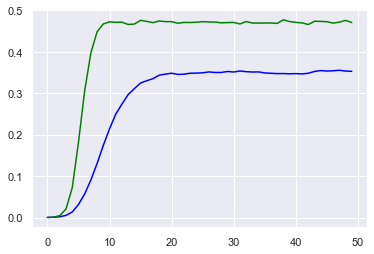

In [24]:
plt.plot(infective_count_average/N, color='blue', label='SIS')
plt.plot(awareness_count_average/N, color='green', label='UAU')

In [25]:
print('N: ', N)
print('infective_count_average: ', infective_count_average)
print('awareness_count_average: ', awareness_count_average)

N:  2000
infective_count_average:  [  1.     1.75   4.2   10.95  27.45  63.2  114.35 182.   261.8  349.1
 428.75 499.55 548.25 594.3  622.8  650.   660.9  671.05 687.85 692.85
 697.15 691.4  692.45 697.25 697.7  699.3  703.45 700.7  700.8  705.6
 702.95 707.8  704.75 702.9  703.5  698.5  696.9  695.25 695.6  694.3
 695.25 693.75 697.   705.65 710.05 707.65 709.05 711.45 707.5  706.35]
awareness_count_average:  [  1.     2.35   9.6   42.   144.6  363.1  612.95 796.15 897.1  935.05
 945.35 942.95 943.65 932.5  934.5  952.55 947.3  941.2  949.25 946.25
 946.2  938.45 942.45 942.   943.3  946.15 944.5  944.05 940.55 941.7
 942.15 935.3  946.55 939.65 939.15 939.5  939.75 937.65 955.35 946.45
 942.55 940.3  932.25 948.05 947.3  946.   939.2  943.8  952.15 941.8 ]
